In [4]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import math
import pandas as pd

In [5]:
def filter_non_digits(string):
    result = ''
    for char in string:
        if char in '1234567890':
            result += char
    return result 

In [6]:
def remove_low(f):
    song, sr = librosa.load(f)
    D = np.abs(librosa.stft(song))
    #FIND OUT HOW MANY FREQUENCIES WE REMOVED HERE! About 10.7*64, 10.7 is the value of librosa.fft_frequencies()[1] 
    D=D[64:]
    DB = librosa.amplitude_to_db(D, ref=np.max)
    return DB

def remove_talking_and_low(f):
    chirp_song, sr = librosa.load(f)
    split=librosa.effects.split(chirp_song, top_db=60)
    chirp_song_split=chirp_song[split[1,0]:split[1,1]]
    if chirp_song_split.shape[0] > 220500:
        chirp_song_split = chirp_song_split[:220500]
    D = np.abs(librosa.stft(chirp_song_split))
    #FIND OUT HOW MANY FREQUENCIES WE REMOVED HERE!
    D=D[64:]
    DB = librosa.amplitude_to_db(D, ref=np.max)
    return DB

In [7]:
def compute_var(DB):
    variance = np.zeros(DB.shape[0])
    for x in range(0,DB.shape[0]):
        variance[x] = np.var(DB[x,:])
    return variance

In [42]:
def main_freq_and_range(f, remove_talk, sound_range = .5):
    if remove_talk:
        variance = compute_var(remove_talking_and_low(f))
    else:
        variance = compute_var(remove_low(f))
    maxfreq = np.argmax(variance)
    maxvar = max(variance)
    if variance[maxfreq] != maxvar:
        print ('failed! at file ', f)
        return None

    #find range of frequencies around the max freq where the animal is loud 
    min_freq_range = 0
    max_freq_range = 0
    i=0
    bool_high =True
    bool_low = True
    while bool_high or bool_low:
        if bool_high:
            if maxfreq+i>len(variance)-1:
                max_freq_range = maxfreq+i
                bool_high = False
            elif variance[maxfreq+i] < sound_range*maxvar:
                #print ('max freq range =', (maxfreq+i+64)*librosa.fft_frequencies()[1])
                max_freq_range = maxfreq+i
                bool_high = False
        if bool_low:
            if maxfreq-i<0:
                min_freq_range = 0
                bool_low = False
            elif variance[maxfreq-i] < sound_range*maxvar:
                #print ('min freq range =', (maxfreq-i+64)*librosa.fft_frequencies()[1])
                min_freq_range = maxfreq-i
                bool_low = False
        i = i+1
    size = (max_freq_range+64)/(min_freq_range+64)
    return (maxfreq+64)*librosa.fft_frequencies()[1], size

In [9]:
def plot_specto(f):
    song,sr = librosa.load(f)
    hop_length = 1024
    n_fft = 2048
    D = np.abs(librosa.stft(song, n_fft=n_fft,  hop_length=hop_length))
    DB = librosa.amplitude_to_db(D, ref=np.max)
    librosa.display.specshow(DB, hop_length=hop_length, x_axis='time', y_axis='log');
    plt.colorbar(format='%+2.0f dB');
    plt.show()
    return None

In [37]:
def get_freq_and_range(directory, remove_talk = False, plot = False, sound_range=.5):
    df = pd.read_csv('MLNS_Insects_fams.csv')
    out = pd.DataFrame(columns = ['genus','main_frequency','range'])
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            #recover type
            file_name = float(filter_non_digits(f))
            genus = df.loc[df.cat_num==file_name].genus
            
            #recover main freq and range
            freq, rang = main_freq_and_range(f, remove_talk, sound_range = sound_range)
            new_row = pd.DataFrame({'genus': genus, 'main_frequency': freq, 'range': rang})
            out = pd.concat([out, new_row])
    return out

def sanity_check(directory, plot = False, remove_talk = False, sound_range = .5):
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            #recover main freq and range
            print (main_freq_and_range(f,remove_talk, sound_range = sound_range))
            plot_specto(f)
    return out

/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_64935/265964968.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([out, new_row])


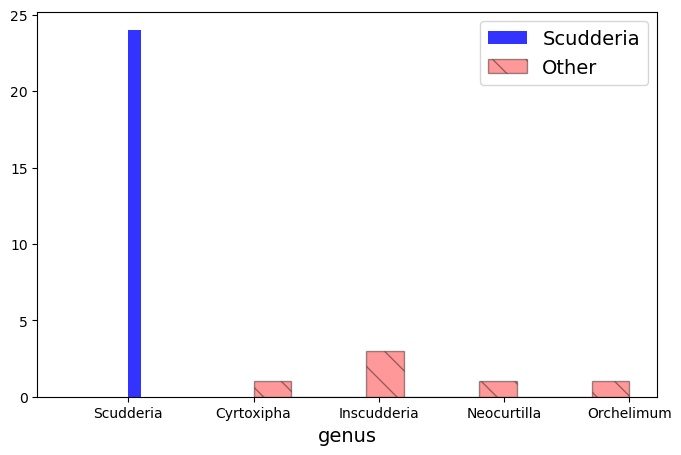

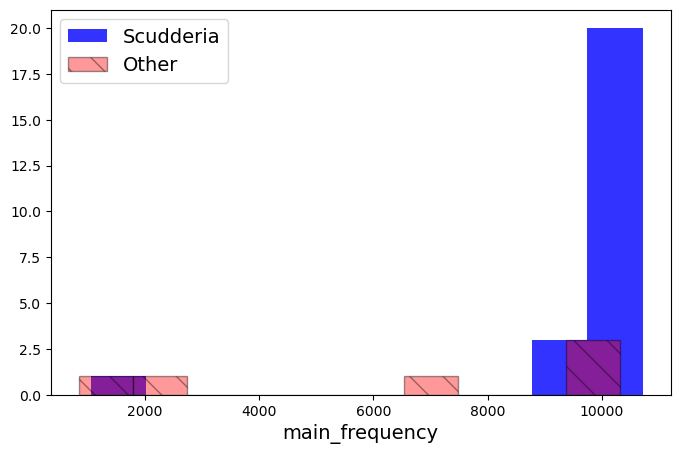

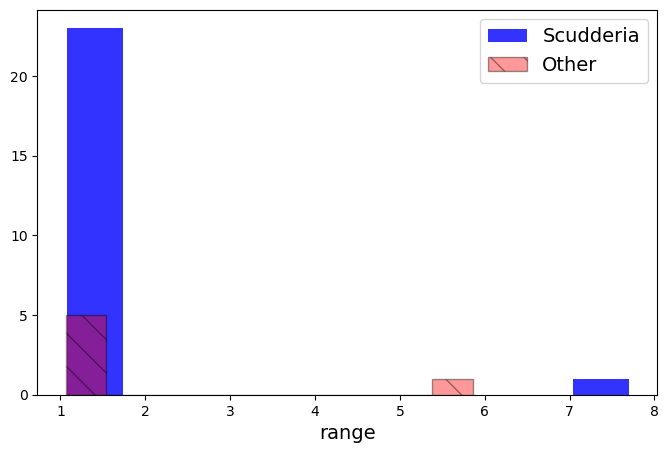

In [44]:
directory = 'Small_audio_sample'

data = get_freq_and_range(directory, plot = False, remove_talk = True, sound_range = .3)
for col in data.columns:
    plt.figure(figsize=(8,5))


    plt.hist(data.loc[data.genus=='Scudderia', col].values,
                color='blue',
                alpha=.8,
                label="Scudderia")

    plt.hist(data.loc[data.genus!='Scudderia', col].values,
                color='red',
                alpha=.4,
                hatch = '\\',
                edgecolor='black',
                label="Other")


    plt.xlabel(col, fontsize=14)
    plt.legend(fontsize=14)

    plt.show()

max freq range = 10680.46875
min freq range = 9496.142578125
(10228.271484375, 1.124716553287982)


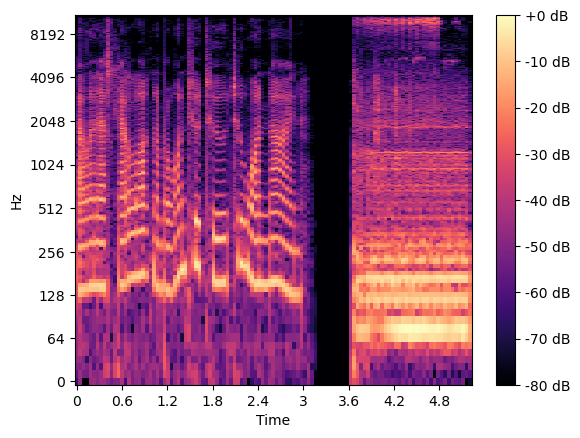

max freq range = 6804.4921875
min freq range = 6610.693359375
(6729.1259765625, 1.0293159609120521)


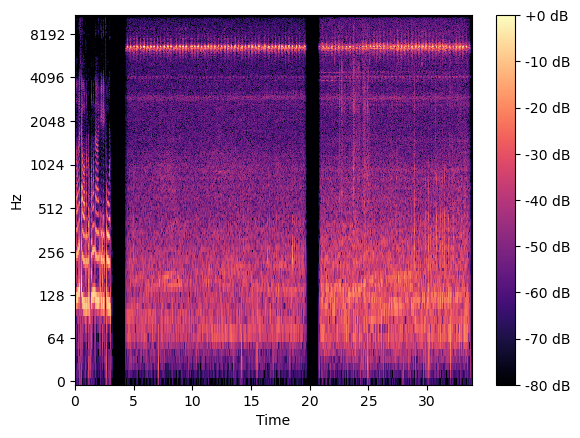

max freq range = 9937.5732421875
min freq range = 9668.408203125
(9894.5068359375, 1.0278396436525612)


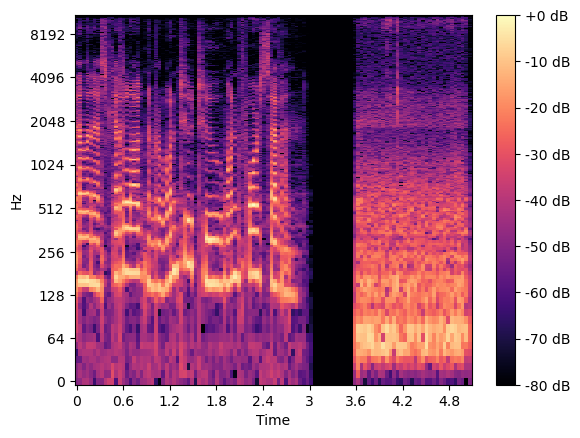

min freq range = 8365.6494140625
max freq range = 9829.9072265625
(8936.279296875, 1.175032175032175)


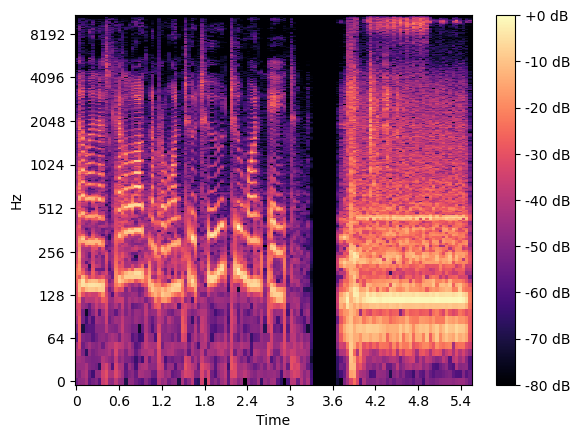

max freq range = 2024.12109375
min freq range = 1582.6904296875
(1873.388671875, 1.2789115646258504)


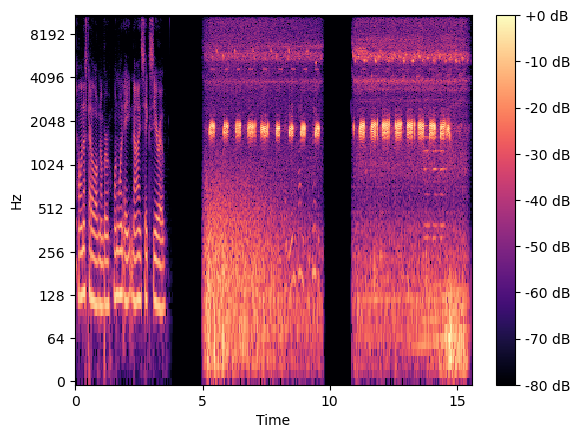

max freq range = 979.7607421875
(839.794921875, 1.421875)


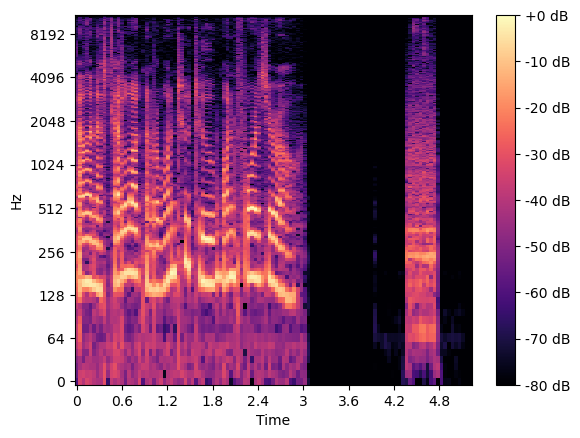

min freq range = 9646.875
max freq range = 10583.5693359375
(9905.2734375, 1.0970982142857142)


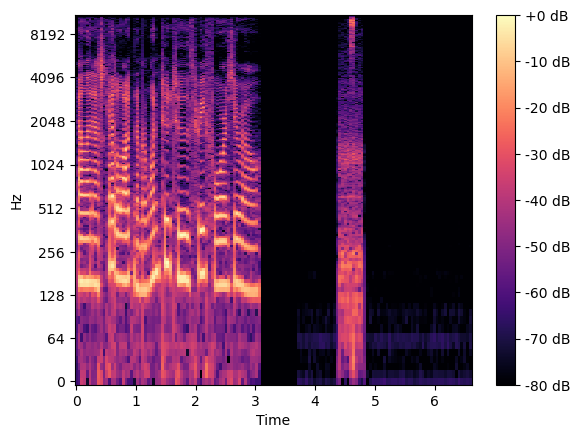

max freq range = 10400.537109375
min freq range = 10185.205078125
(10325.1708984375, 1.0211416490486258)


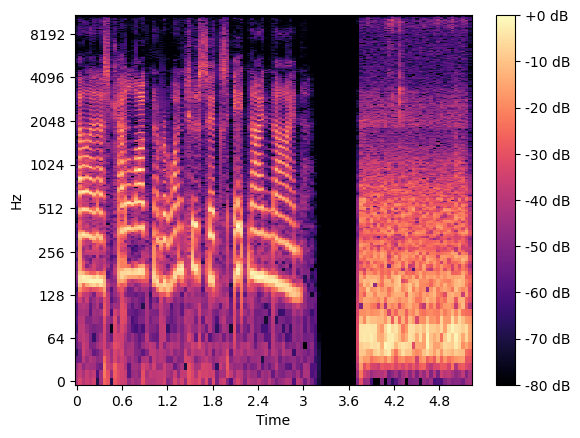

min freq range = 9560.7421875
max freq range = 10766.6015625
(10023.7060546875, 1.1261261261261262)


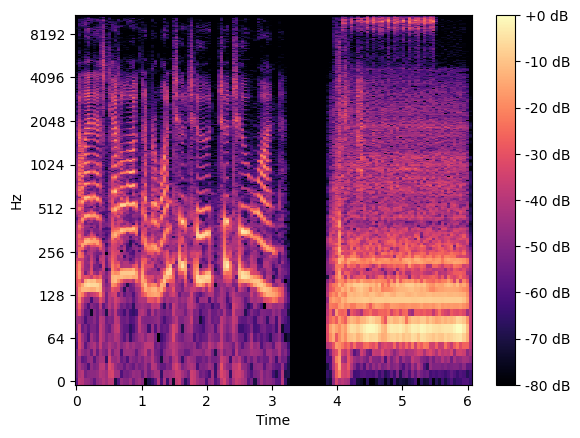

max freq range = 10400.537109375
min freq range = 9894.5068359375
(10185.205078125, 1.0511425462459194)


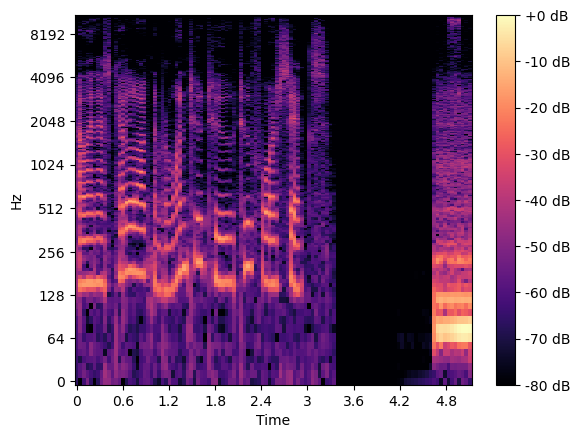

max freq range = 10648.1689453125
min freq range = 9829.9072265625
(10357.470703125, 1.0832420591456735)


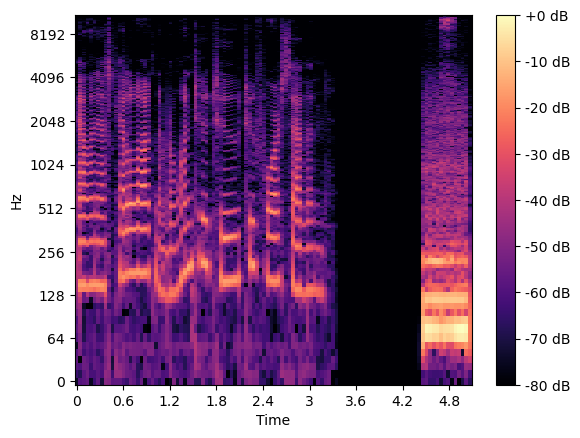

min freq range = 10034.47265625
max freq range = 10766.6015625
(10314.404296875, 1.0729613733905579)


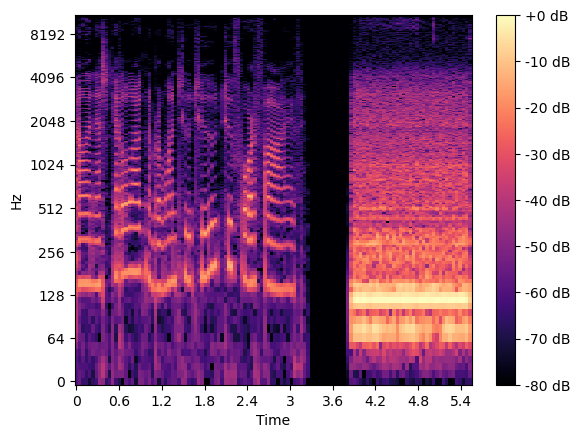

max freq range = 10841.9677734375
min freq range = 9926.806640625
(10605.1025390625, 1.0921908893709327)


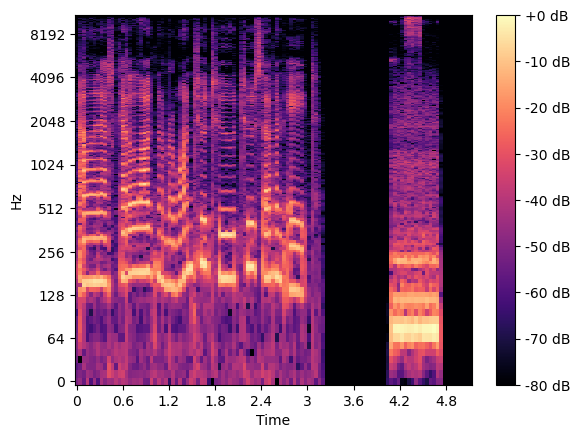

max freq range = 10852.734375
min freq range = 9442.3095703125
(10712.7685546875, 1.1493728620296466)


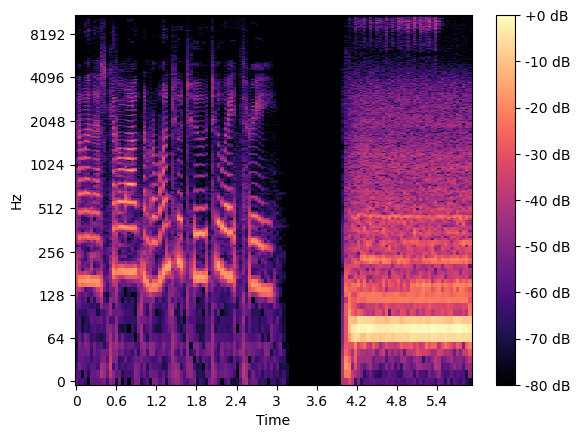

max freq range = 10820.4345703125
min freq range = 10152.9052734375
(10669.7021484375, 1.0657476139978792)


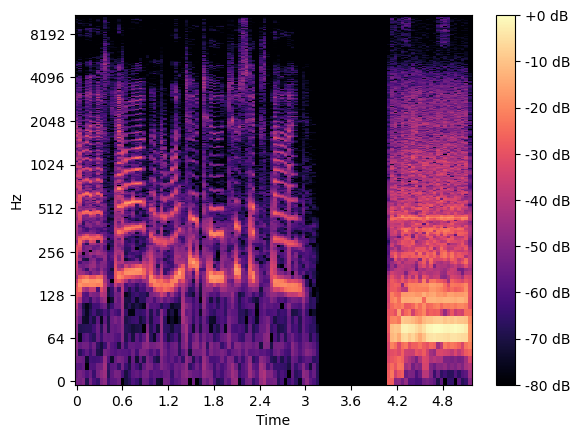

max freq range = 10788.134765625
min freq range = 8118.017578125
(9872.9736328125, 1.3289124668435013)


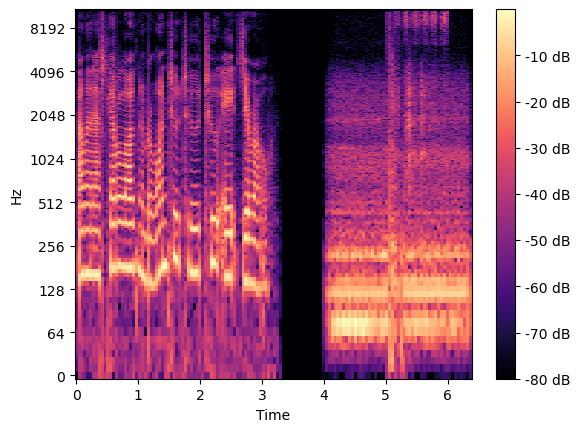

min freq range = 9216.2109375
max freq range = 10820.4345703125
(9754.541015625, 1.1740654205607477)


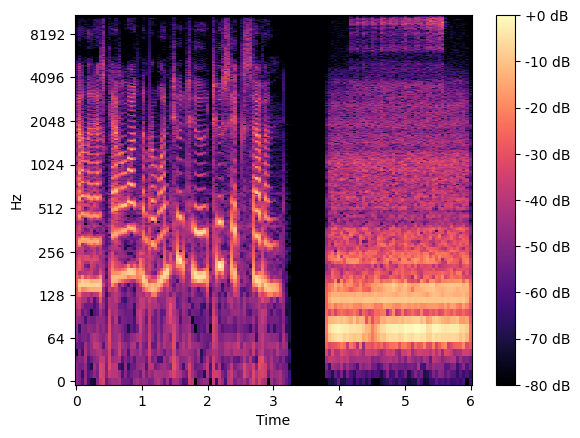

max freq range = 10766.6015625
min freq range = 9097.7783203125
(10551.26953125, 1.183431952662722)


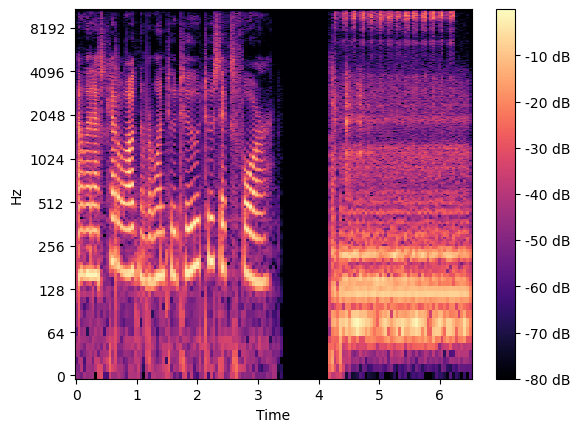

max freq range = 10831.201171875
min freq range = 10109.8388671875
(10637.40234375, 1.071352502662407)


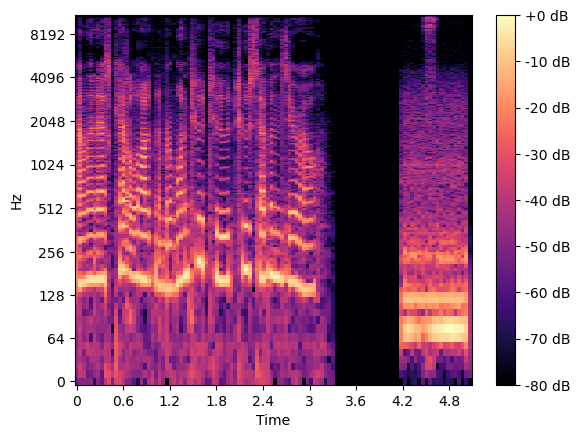

max freq range = 2497.8515625
(1044.3603515625, 3.625)


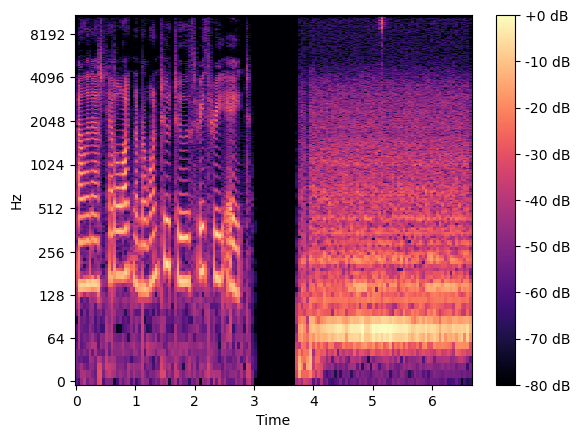

max freq range = 10745.068359375
min freq range = 10077.5390625
(10605.1025390625, 1.0662393162393162)


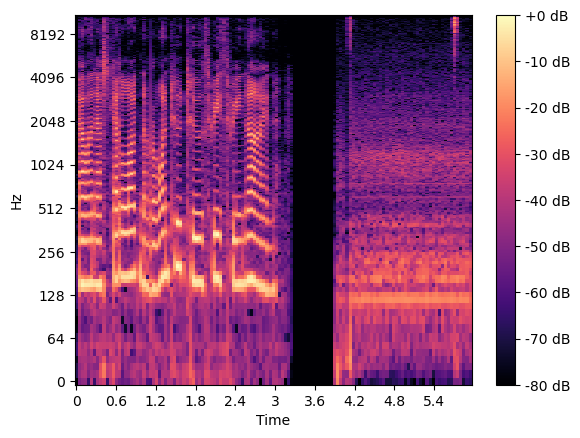

min freq range = 8441.015625
max freq range = 10777.3681640625
(9237.744140625, 1.2767857142857142)


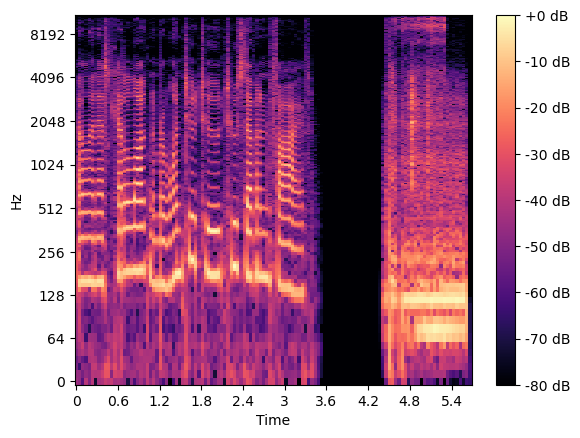

max freq range = 10809.66796875
min freq range = 9959.1064453125
(10626.6357421875, 1.0854054054054054)


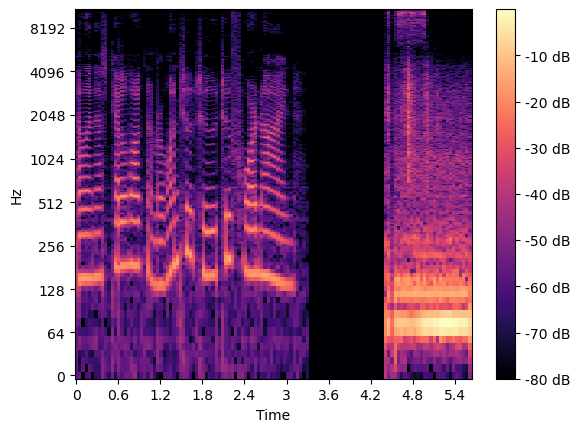

max freq range = 10820.4345703125
min freq range = 9959.1064453125
(10583.5693359375, 1.0864864864864865)


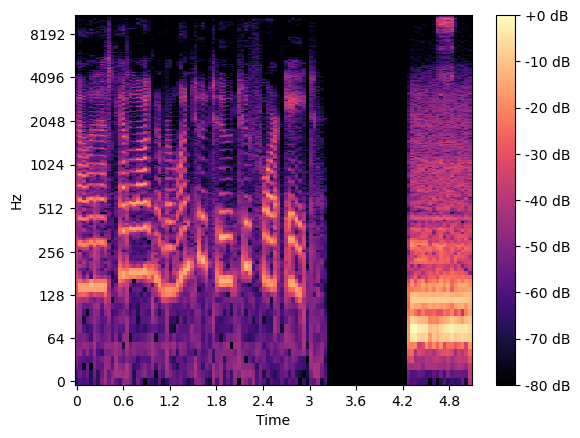

min freq range = 10292.87109375
max freq range = 10798.9013671875
(10529.736328125, 1.049163179916318)


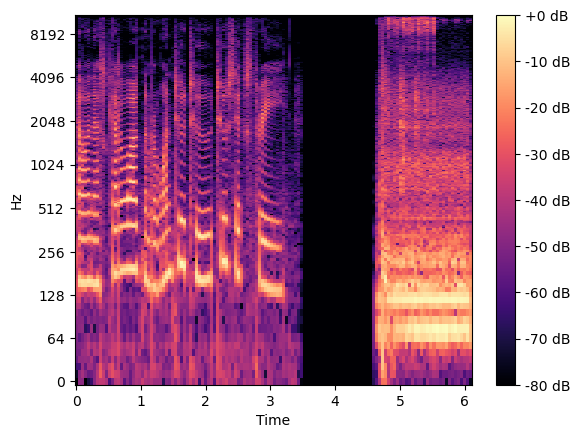

max freq range = 10691.2353515625
min freq range = 9463.8427734375
(10497.4365234375, 1.129692832764505)


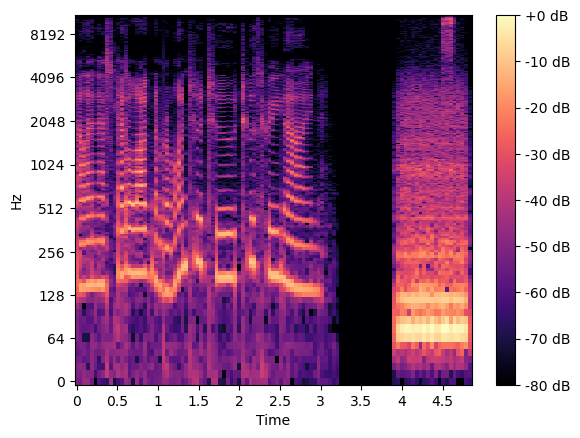

min freq range = 8257.9833984375
max freq range = 10745.068359375
(9388.4765625, 1.3011734028683182)


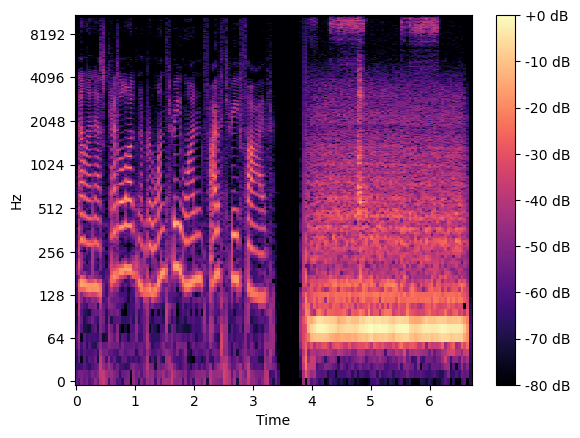

min freq range = 9463.8427734375
max freq range = 10195.9716796875
(9679.1748046875, 1.0773606370875994)


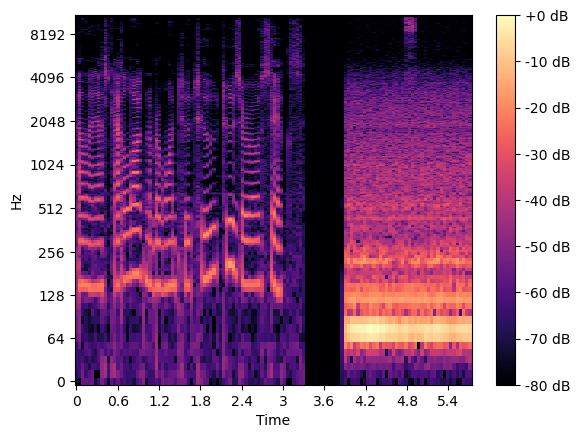

min freq range = 9689.94140625
max freq range = 10314.404296875
(9937.5732421875, 1.0644444444444445)


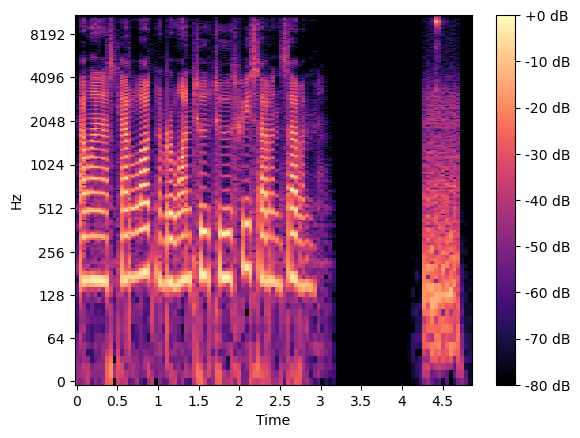

min freq range = 9485.3759765625
max freq range = 10680.46875
(9926.806640625, 1.1259931895573212)


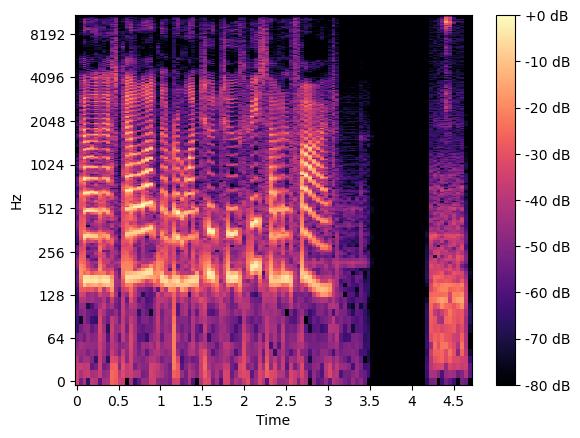

NameError: name 'out' is not defined

In [32]:
directory = 'Small_audio_sample'
sanity_check(directory, plot = False, remove_talk = True)